In [1]:
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose
import matplotlib.pyplot as plt

# architecture: https://github.com/AKASHKADEL/dcgan-mnist/blob/master/main.py

device = "cuda" if torch.cuda.is_available() else "cpu"

class GeneratorNet(nn.Module):
  def __init__(self, z_dim):
    super().__init__()
    self.net = nn.Sequential(
      nn.ConvTranspose2d(z_dim, 32*4, 4, 1, 0, bias=False),
      nn.BatchNorm2d(32*4), nn.ReLU(True),
      nn.ConvTranspose2d(32*4, 32*2, 3, 2, 1, bias=False),
      nn.BatchNorm2d(32*2), nn.ReLU(True),
      nn.ConvTranspose2d(32*2, 32, 4, 2, 1, bias=False),
      nn.BatchNorm2d(32), nn.ReLU(True),
      nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
      nn.Sigmoid()
    )

  def forward(self, z):
    x = self.net(z)
    return x

class DiscriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
      nn.Conv2d(1, 32, 4, 2, 1, bias=False),
      nn.LeakyReLU(0.2, True),
      nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(32 * 2), nn.LeakyReLU(0.2, True),
      nn.Conv2d(32 * 2, 32 * 4, 3, 2, 1, bias=False),
      nn.BatchNorm2d(32 * 4), nn.LeakyReLU(0.2, True),
      nn.Conv2d(32 * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid(), nn.Flatten(1)
    )

  def forward(self, x):
    return self.net(x).flatten(1)
    
criterion = nn.BCELoss()

def g_loss(x_fake, d):
  return criterion(d(x_fake), torch.ones(x_fake.size(0), device=x_fake.device).unsqueeze(1))

def d_loss(x_real, x_fake, d):
  return (criterion(d(x_real), torch.ones(x_real.size(0), device=x_fake.device).unsqueeze(1)) + criterion(d(x_fake), torch.zeros(x_real.size(0), device=x_fake.device).unsqueeze(1))) / 2

def train(batch_size=128, epochs=100, lr_g=2e-4, lr_d=2e-4, k=1, k2=1, z_dim=100, seed=42):
  torch.manual_seed(seed)
  X = datasets.MNIST(root="data", download=True, transform=ToTensor())
  dl = DataLoader(X, batch_size=batch_size, shuffle=True, drop_last=True)

  g_net = GeneratorNet(z_dim=z_dim).to(device)
  d_net = DiscriminatorNet().to(device)
  opt_g = torch.optim.Adam(g_net.parameters(), lr=lr_g)
  opt_d = torch.optim.Adam(d_net.parameters(), lr=lr_d)

  def sample_fake(m):
    z = torch.randn(m, z_dim, 1, 1, device=device)
    return g_net(z)

  losses_g = []
  losses_d = []
  running_loss_g = 0
  running_loss_d = 0
  last_epoch = 0
  for epoch in range(1, epochs + 1):
    g_net.train()
    d_net.train()
    epoch_loss_g = 0
    epoch_loss_d = 0
    for (x, _) in dl:
      x = x.to(device)
      m = batch_size
      for _ in range(k):
        x_fake = sample_fake(m)
        loss_d = d_loss(x, x_fake, d_net)
        epoch_loss_d += loss_d.item()
        opt_d.zero_grad()
        loss_d.backward()
        running_loss_d += loss_d.item()
        opt_d.step()
      for _ in range(k2):
        x_fake = sample_fake(m)
        loss_g = g_loss(x_fake, d_net)
        epoch_loss_g += loss_g.item()
        opt_g.zero_grad()
        loss_g.backward()
        running_loss_g += loss_g.item()
        opt_g.step()
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    def plot_losses():
      plt.figure(figsize=(2, 1.5))
      plt.plot(range(1, epoch + 1), losses_g, range(1, epoch + 1), losses_d)
      plt.tight_layout()
      plt.show()
    if epoch % 1 == 0:
      print(f'[{epoch}] Generator loss: {running_loss_g / (epoch - last_epoch) / k2}')
      print(f'[{epoch}] Discriminator loss: {running_loss_d / (epoch - last_epoch) / k}')
      running_loss_g = 0
      running_loss_d = 0
      last_epoch = epoch
    if epoch % 5 == 0:
      print(f'[{epoch}]')
      plot_losses()
      visualize(z_dim=z_dim, n=4, g_net_=g_net, d_net_=d_net)
  return g_net, d_net

@torch.no_grad()
def visualize(z_dim=100, n=1, g_net_=None, d_net_=None):
  assert g_net_ is not None and d_net_ is not None
  def sample_fake(m):
    z = torch.randn(m, z_dim, 1, 1, device=device)
    return g_net_(z)
  x_fake = sample_fake(n)
  scores = d_net_(x_fake)
  fig, ax = plt.subplots(1, n, figsize=(1.5 * n, 2))
  for i, x in enumerate(x_fake):
    img = x.cpu().permute(1, 2, 0)
    score = scores[i].cpu().item()
    ax[i].axis('off')
    ax[i].imshow(img, cmap='grey')
    ax[i].text(0.5, -0.25, f'D(G(z)) = {score:.2f}', transform=ax[i].transAxes, ha='center')
  plt.tight_layout()
  plt.show()

print(f'Ready to begin training with {device}.')

Ready to begin training with cuda.


[1] Generator loss: 2879.4814215898514
[1] Discriminator loss: 7.621054918272421
[2] Generator loss: 2897.0585193634033
[2] Discriminator loss: 7.003395114792511
[3] Generator loss: 2981.0688791275024
[3] Discriminator loss: 7.497693069977686
[4] Generator loss: 2644.700587749481
[4] Discriminator loss: 13.013238667044789
[5] Generator loss: 2538.944803953171
[5] Discriminator loss: 13.67293793708086
[5]


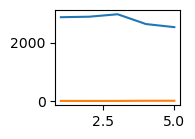

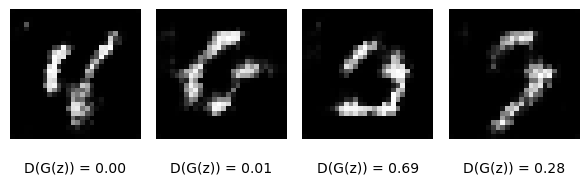

[6] Generator loss: 2416.5686728954315
[6] Discriminator loss: 18.039811708033085
[7] Generator loss: 2365.959321975708
[7] Discriminator loss: 26.963538493495435
[8] Generator loss: 2064.933258295059
[8] Discriminator loss: 39.66003298945725
[9] Generator loss: 1916.5150077342987
[9] Discriminator loss: 52.85815284587443
[10] Generator loss: 1693.8570243120193
[10] Discriminator loss: 62.366632115095854
[10]


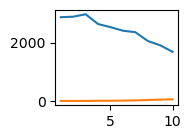

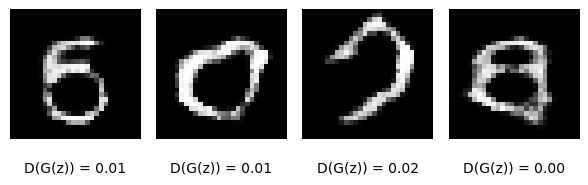

[11] Generator loss: 1537.6674485206604
[11] Discriminator loss: 78.12495780363679
[12] Generator loss: 1529.884775876999
[12] Discriminator loss: 91.49756885319948
[13] Generator loss: 1355.4065363407135
[13] Discriminator loss: 95.46641183644533
[14] Generator loss: 1268.2946045398712
[14] Discriminator loss: 102.6686944887042
[15] Generator loss: 1288.891206741333
[15] Discriminator loss: 107.79444548487663
[15]


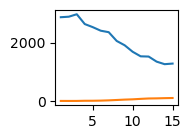

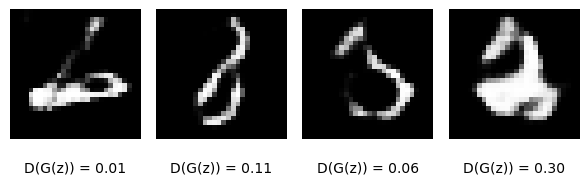

[16] Generator loss: 1274.6442697048187
[16] Discriminator loss: 121.58604474365711
[17] Generator loss: 1190.237550497055
[17] Discriminator loss: 117.78533705323935
[18] Generator loss: 1124.0520614385605
[18] Discriminator loss: 122.35125096142292
[19] Generator loss: 1163.795766055584
[19] Discriminator loss: 129.08212506771088
[20] Generator loss: 1068.482438325882
[20] Discriminator loss: 135.4599442332983
[20]


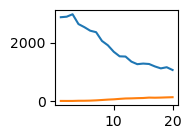

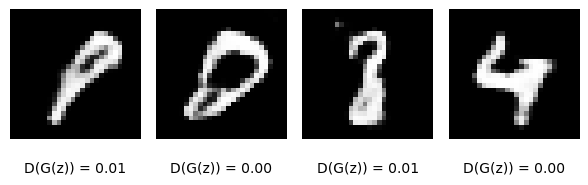

[21] Generator loss: 1074.5337808728218
[21] Discriminator loss: 133.0640124976635
[22] Generator loss: 1001.213263630867
[22] Discriminator loss: 137.67159023880959
[23] Generator loss: 1066.7196298837662
[23] Discriminator loss: 144.7574158385396
[24] Generator loss: 1030.4479367733002
[24] Discriminator loss: 145.33352234959602
[25] Generator loss: 992.3151302933693
[25] Discriminator loss: 148.76865081489086
[25]


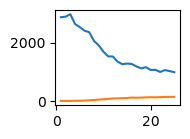

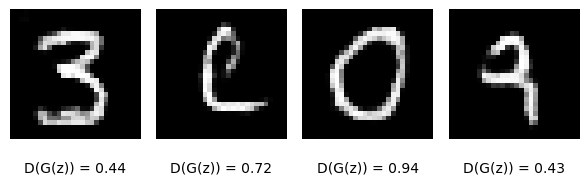

[26] Generator loss: 974.7368134260178
[26] Discriminator loss: 146.00311170518398
[27] Generator loss: 958.7875669002533
[27] Discriminator loss: 152.98623818159103
[28] Generator loss: 993.6790415048599
[28] Discriminator loss: 147.29645612835884
[29] Generator loss: 1036.3720710873604
[29] Discriminator loss: 156.12306509912014
[30] Generator loss: 945.8988960981369
[30] Discriminator loss: 153.95738644897938
[30]


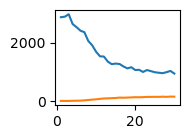

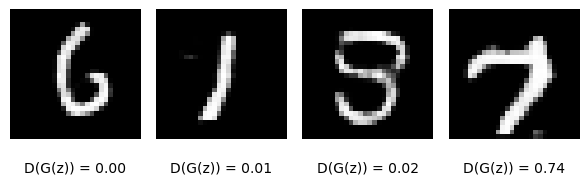

[31] Generator loss: 895.1681231856346
[31] Discriminator loss: 148.48509812355042
[32] Generator loss: 920.6340743899345
[32] Discriminator loss: 146.7319738715887
[33] Generator loss: 941.7444001436234
[33] Discriminator loss: 150.97577414661646
[34] Generator loss: 932.5424128174782
[34] Discriminator loss: 148.06038418412209
[35] Generator loss: 930.3639736771584
[35] Discriminator loss: 148.05311857163906
[35]


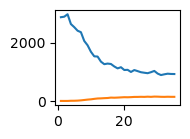

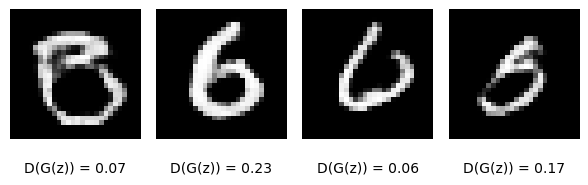

[36] Generator loss: 937.9404456615448
[36] Discriminator loss: 150.26641161739826
[37] Generator loss: 943.206885933876
[37] Discriminator loss: 150.17057412862778
[38] Generator loss: 953.2599843740463
[38] Discriminator loss: 150.66965487599373
[39] Generator loss: 899.448797762394
[39] Discriminator loss: 145.09180511534214
[40] Generator loss: 943.7703823447227
[40] Discriminator loss: 142.02353218197823
[40]


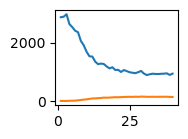

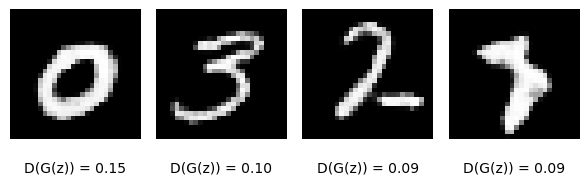

[41] Generator loss: 934.5221386551857
[41] Discriminator loss: 150.10050058364868
[42] Generator loss: 976.4147775173187
[42] Discriminator loss: 150.27159541845322
[43] Generator loss: 922.1359056830406
[43] Discriminator loss: 147.82509396970272
[44] Generator loss: 960.4864686727524
[44] Discriminator loss: 143.24682265520096
[45] Generator loss: 984.8953758478165
[45] Discriminator loss: 146.50024320930243
[45]


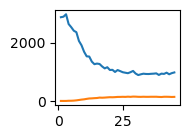

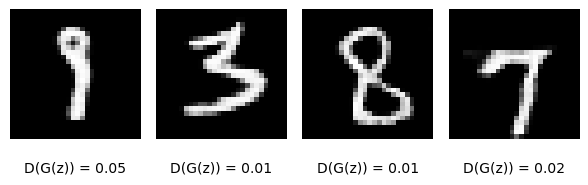

[46] Generator loss: 932.9806023240089
[46] Discriminator loss: 144.74690687656403
[47] Generator loss: 944.7744588255882
[47] Discriminator loss: 142.85080144554377
[48] Generator loss: 939.7596125006676
[48] Discriminator loss: 136.26676673442125
[49] Generator loss: 947.6323418021202
[49] Discriminator loss: 134.50921944528818
[50] Generator loss: 997.7761849164963
[50] Discriminator loss: 139.82610546052456
[50]


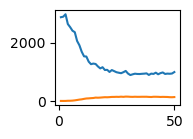

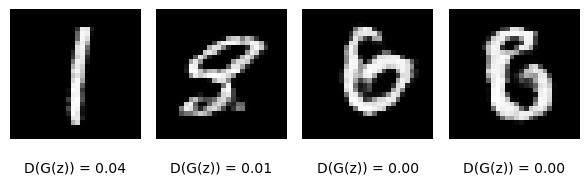

[51] Generator loss: 984.287839859724
[51] Discriminator loss: 139.35647554695606
[52] Generator loss: 940.864894092083
[52] Discriminator loss: 135.25228821486235
[53] Generator loss: 977.7929222583771
[53] Discriminator loss: 135.17973946034908
[54] Generator loss: 986.7055314779282
[54] Discriminator loss: 138.95847403258085
[55] Generator loss: 985.0854705572128
[55] Discriminator loss: 128.72330452501774
[55]


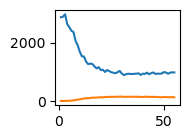

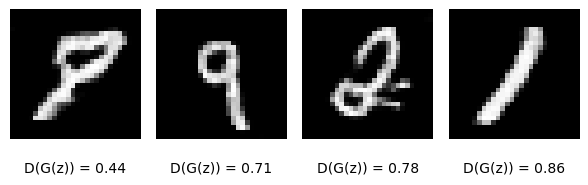

[56] Generator loss: 995.8539207577705
[56] Discriminator loss: 130.8477471768856
[57] Generator loss: 1019.6287190318108
[57] Discriminator loss: 125.68739824742079
[58] Generator loss: 1015.4152064323425
[58] Discriminator loss: 128.6954779177904
[59] Generator loss: 986.6076452732086
[59] Discriminator loss: 129.06070443242788
[60] Generator loss: 1005.5238445997238
[60] Discriminator loss: 125.94720899313688
[60]


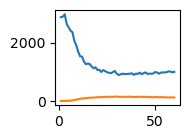

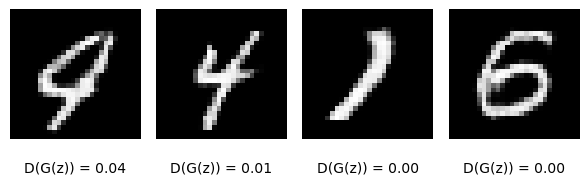

[61] Generator loss: 973.3313275575638
[61] Discriminator loss: 122.5597831606865
[62] Generator loss: 1035.4130439162254
[62] Discriminator loss: 123.82417030632496
[63] Generator loss: 1000.0126077532768
[63] Discriminator loss: 126.16041323542595
[64] Generator loss: 1011.0041311383247
[64] Discriminator loss: 123.96155908703804
[65] Generator loss: 1025.469853758812
[65] Discriminator loss: 120.95896004885435
[65]


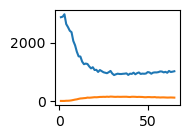

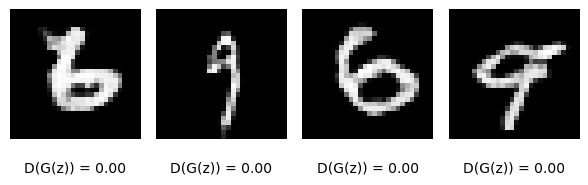

[66] Generator loss: 1037.7297661304474
[66] Discriminator loss: 118.4522570297122
[67] Generator loss: 1056.4029622077942
[67] Discriminator loss: 117.07114703208208
[68] Generator loss: 1034.7066011428833
[68] Discriminator loss: 122.3277834802866
[69] Generator loss: 1043.1542090177536
[69] Discriminator loss: 117.08662232011557
[70] Generator loss: 1068.393933802843
[70] Discriminator loss: 116.91885631531477
[70]


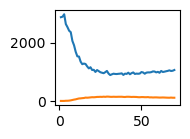

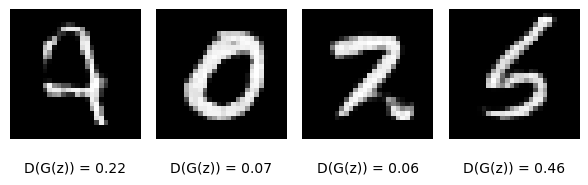

[71] Generator loss: 1058.9030174016953
[71] Discriminator loss: 113.82162065804005
[72] Generator loss: 1072.950088262558
[72] Discriminator loss: 115.90595630556345
[73] Generator loss: 1044.9180143475533
[73] Discriminator loss: 115.98079106211662
[74] Generator loss: 1075.8690629601479
[74] Discriminator loss: 117.89811777323484
[75] Generator loss: 1062.7392905652523
[75] Discriminator loss: 114.80601842701435
[75]


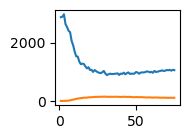

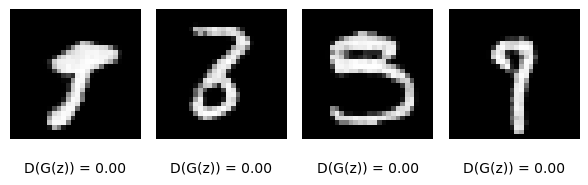

[76] Generator loss: 1073.1042848825455
[76] Discriminator loss: 112.4876733198762
[77] Generator loss: 1113.0101605057716
[77] Discriminator loss: 112.5432745590806
[78] Generator loss: 1093.5340561270714
[78] Discriminator loss: 113.82970727980137
[79] Generator loss: 1101.8156599998474
[79] Discriminator loss: 110.54898565262556
[80] Generator loss: 1124.6911826729774
[80] Discriminator loss: 116.04011134803295
[80]


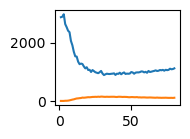

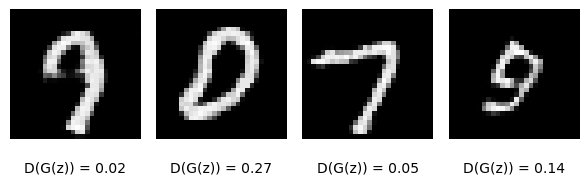

[81] Generator loss: 1091.6048645973206
[81] Discriminator loss: 114.20284728705883
[82] Generator loss: 1116.2218960523605
[82] Discriminator loss: 111.74821055680513
[83] Generator loss: 1127.6468421816826
[83] Discriminator loss: 108.92829253897071
[84] Generator loss: 1118.6059032082558
[84] Discriminator loss: 113.90355618298054
[85] Generator loss: 1119.0467462539673
[85] Discriminator loss: 107.94529742002487
[85]


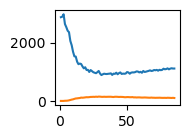

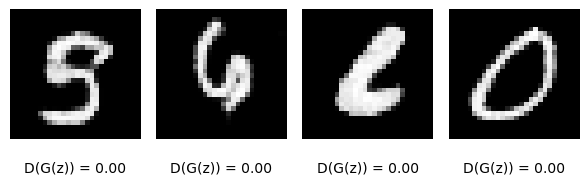

[86] Generator loss: 1120.7181891798973
[86] Discriminator loss: 108.66375108063221
[87] Generator loss: 1133.958039432764
[87] Discriminator loss: 111.38246922940016
[88] Generator loss: 1095.0791769623756
[88] Discriminator loss: 104.57929967343807
[89] Generator loss: 1132.7659232616425
[89] Discriminator loss: 106.59082430973649
[90] Generator loss: 1135.9682049751282
[90] Discriminator loss: 102.99392895400524
[90]


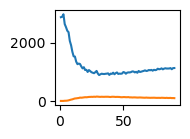

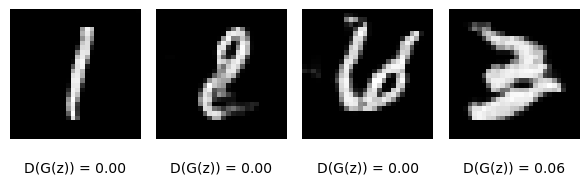

[91] Generator loss: 1133.3031875491142
[91] Discriminator loss: 105.5956528633833
[92] Generator loss: 1159.1706485152245
[92] Discriminator loss: 100.54121598228812
[93] Generator loss: 1155.7724979519844
[93] Discriminator loss: 107.01828336715698
[94] Generator loss: 1154.7874702811241
[94] Discriminator loss: 103.52449146658182
[95] Generator loss: 1141.0055403113365
[95] Discriminator loss: 105.0246193036437
[95]


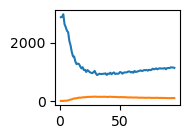

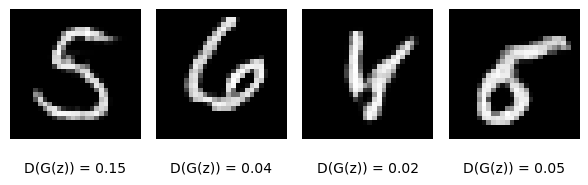

[96] Generator loss: 1122.7901439070702
[96] Discriminator loss: 99.91194029897451
[97] Generator loss: 1176.3121693730354
[97] Discriminator loss: 100.39789845049381
[98] Generator loss: 1157.8109876513481
[98] Discriminator loss: 106.06953464448452
[99] Generator loss: 1175.9920612573624
[99] Discriminator loss: 96.35108641535044
[100] Generator loss: 1165.9689357876778
[100] Discriminator loss: 98.24599052220583
[100]


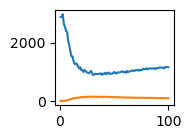

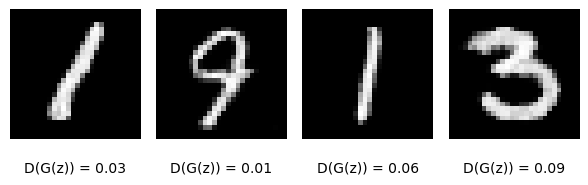

In [2]:
if __name__ == '__main__':
  g_net, d_net = train()

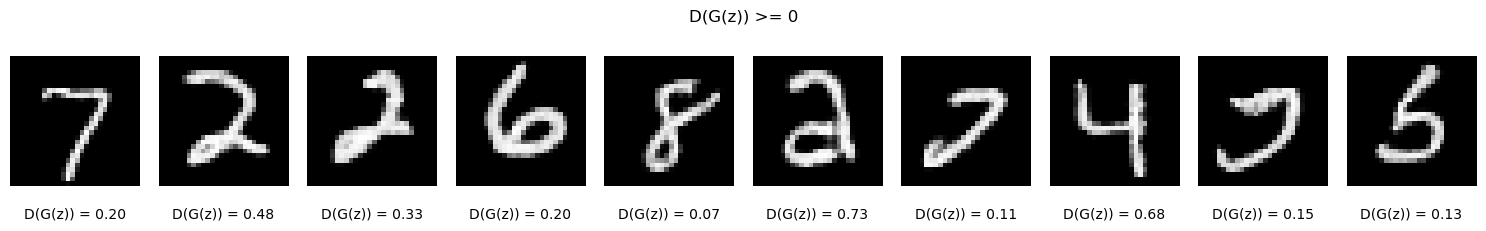

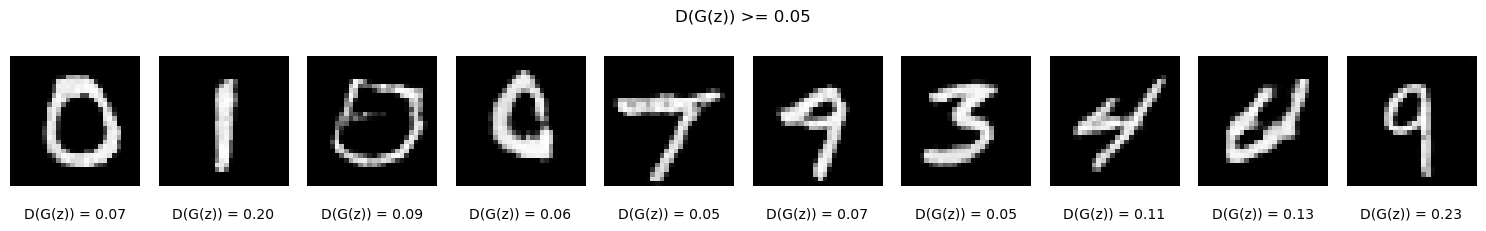

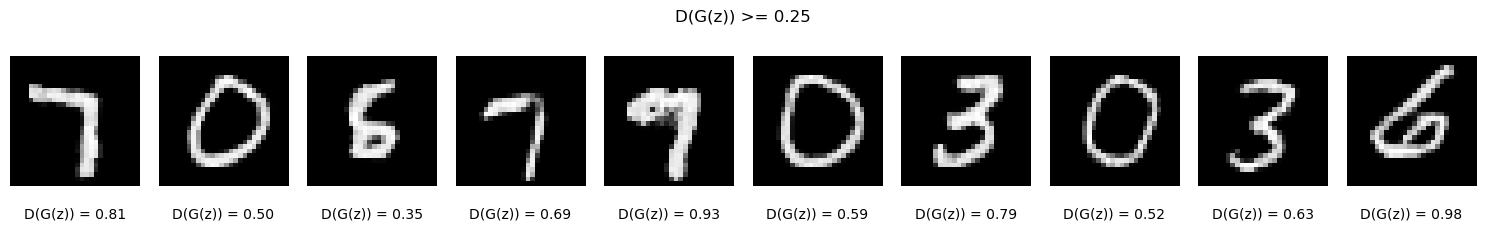

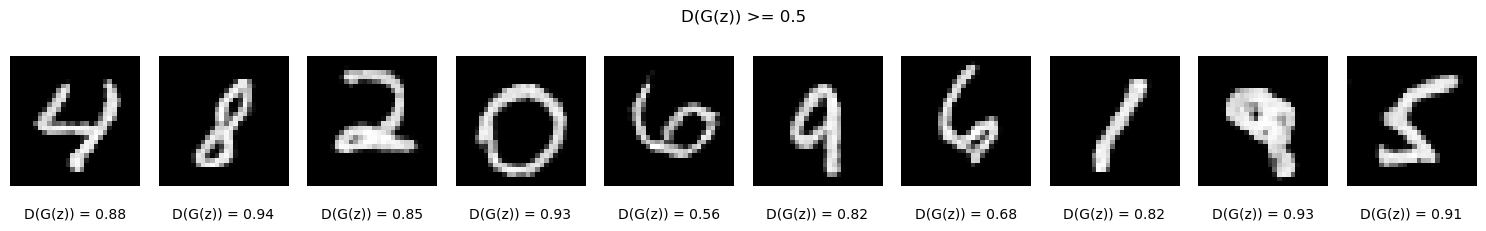

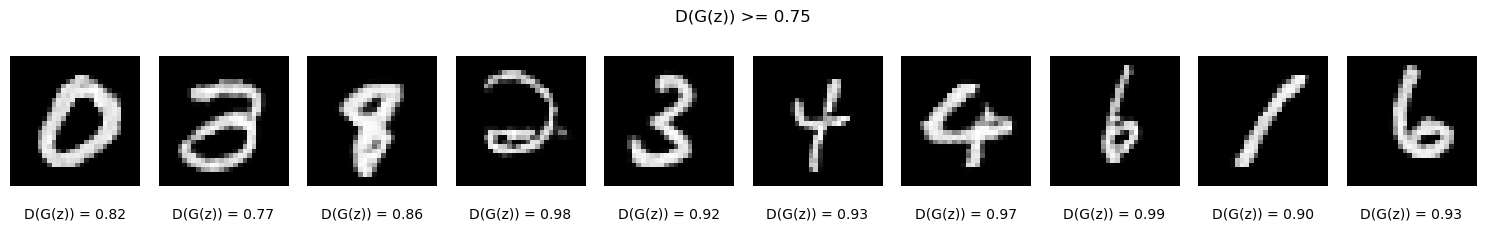

In [11]:
@torch.no_grad()
def visualize_final(z_dim=100, n=1, g_net_=None, d_net_=None, threshold=0.05, max_tries=1000):
  assert g_net_ is not None and d_net_ is not None
  def sample_fake(m):
    try_ = 0
    while try_ < max_tries:
      z = torch.randn(m, z_dim, 1, 1, device=device)
      x_fake = g_net_(z)
      if torch.all(d_net_(x_fake) >= threshold):
        return x_fake
      try_ += 1
    return None
  x_fake = sample_fake(n)
  if x_fake is None:
    return
  scores = d_net_(x_fake)
  fig, ax = plt.subplots(1, n, figsize=(1.5 * n, 2))
  plt.suptitle(f'D(G(z)) >= {threshold}')
  for i, x in enumerate(x_fake):
    img = x.cpu().permute(1, 2, 0)
    score = scores[i].cpu().item()
    ax[i].axis('off')
    ax[i].imshow(img, cmap='grey')
    ax[i].text(0.5, -0.25, f'D(G(z)) = {score:.2f}', transform=ax[i].transAxes, ha='center')
  plt.tight_layout()
  plt.show()

visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=0)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=0.05)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=0.25)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=0.5)
visualize_final(n=10, g_net_=g_net, d_net_=d_net, threshold=0.75)